In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
import itertools
from scipy import linalg
import matplotlib as mpl
%matplotlib inline

In [283]:
df = pd.read_csv("./Data/Wholesale customers data.csv")

In [290]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [295]:
df.describe()
# Channel has 2 categories
# Region has 3 categories

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


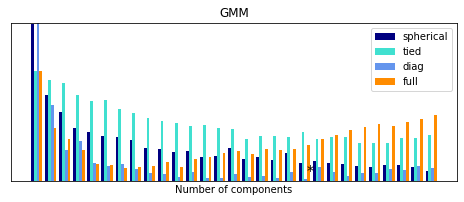

In [296]:
def gmm_fit(df):
    sc = StandardScaler()
    df_z_scaled = df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]
    df_z_scaled = sc.fit_transform(df_z_scaled)

    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 30)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
            gmm.fit(df_z_scaled)
            bic.append(gmm.bic(df_z_scaled))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    plt.xticks(())
    plt.yticks(())
    plt.title('GMM')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.show()
    return df_z_scaled

df_z_scaled = gmm_fit(df)



In [297]:
gmm_final = mixture.GaussianMixture(n_components=15,
                                      covariance_type="diag")
gmm_final.fit(df_z_scaled)
groups = gmm_final.predict(df_z_scaled)

In [298]:
print(groups)

[ 9  9  9 10 11  9  9  9  6 13  1  6  9 13  9  6  1  5  9  9  9  0 11  8
  9  9  0  0  7  5  9  6  5  5  0  1  5 13 13 11 11  9 13 13  9  7 13  3
  9  7 10  6  9  1  5  6  7  1  0  9  9  3  1 13 10  7  1  9 10  6 10 12
 10 10  9  0 10 13  0  6  6  1  9  0  9  3  3 12 10  5  0 10  7 14  1  6
  1  0  0  0 13 13  1 11  6  6  1 13  1 13  0 13 10 10  0  0  0  6  0  0
  0  0  0  9  5 11 10  9  6  5 10  0  6  0  0  0  1  1  5  6  9 11 11 10
  6  3  0  6  0  5  0  6  0  6  0 13 13 10  1  1  1  5  0 13  1 13  9  6
  0  0  1  7  1 13  5  1 11  9  6 10  9 11  1  2  6  6 10  1  1  1 10  0
  0 13  0 10 11  1 10  0 13 13 11  6  6 13  0  1  1 13  5  7  6  1  1 13
  7  0  9  0  0  1 10 10  0  6  9  0  1 10 10  1  5  6  5  6  0 10  0  5
 10  0  0  9  9 13  0  0  6 10  0  7 10  9 11  0  6  1  5  5  6  0  0  1
  1 11 13  5 13  0  0  6  1  5  6  0  5 10 10  9  6  9  5 10 11  5  6 10
  0  5  6 10 10  1  5  6 10  9  1  0  9 13  1 13 13  1 13  0  0 13 10  5
 13  0  6  9  0  6 10  7  6 10 10  9  5  4  0  0 10

In [299]:
groups = pd.Series(groups)
groups.value_counts().sort_values(ascending=False)

0     93
10    59
6     56
1     55
9     53
13    44
5     38
11    19
7     11
3      6
12     2
2      1
4      1
8      1
14     1
dtype: int64

In [300]:
df["gmm"] = groups  

In [301]:
print(df[df["gmm"]==2])
print(df[df["gmm"]==4])
print(df[df["gmm"]==8])
print(df[df["gmm"]==14])

     Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
183        1       3  36847  43950    20170   36534               239   

     Delicassen  gmm  
183       47943    2  
     Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
325        1       2  32717  16784    13626   60869              1272   

     Delicassen  gmm  
325        5609    4  
    Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
23        2       3  26373  36423    22019    5154              4337   

    Delicassen  gmm  
23       16523    8  
    Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  \
93        1       3  11314  3090     2062   35009                71   

    Delicassen  gmm  
93        2698   14  


In [302]:
df = df.drop(index=183, axis=0)
df = df.drop(index=325, axis=0)
df = df.drop(index=23, axis=0)
df = df.drop(index=93, axis=0)

In [303]:
df["gmm"].value_counts().sort_values(ascending=False)

0     93
10    59
6     56
1     55
9     53
13    44
5     38
11    19
7     11
3      6
12     2
Name: gmm, dtype: int64

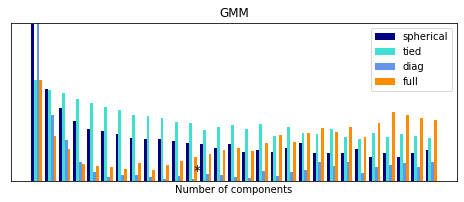

In [304]:
df_z_scaled = gmm_fit(df)

In [305]:
gmm_final = mixture.GaussianMixture(n_components=12,
                                      covariance_type="diag")
gmm_final.fit(df_z_scaled)
groups = gmm_final.predict(df_z_scaled)
df["gmm"] = groups
df["gmm"].value_counts().sort_values(ascending=False)

4     80
0     73
3     61
9     56
5     50
10    45
7     44
1     10
2     10
11     4
6      2
8      1
Name: gmm, dtype: int64

In [306]:
df[df["gmm"]==8]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,gmm
86,2,3,22925,73498,32114,987,20070,903,8


In [307]:
df = df.drop(index=86, axis=0)

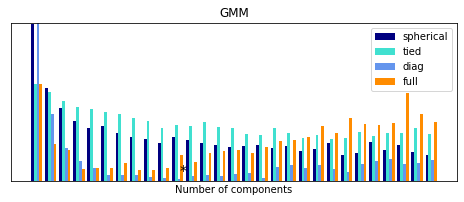

In [308]:
df_z_scaled = gmm_fit(df)

In [309]:
gmm_final = mixture.GaussianMixture(n_components=11,
                                      covariance_type="diag")
gmm_final.fit(df_z_scaled)
groups = gmm_final.predict(df_z_scaled)
df["gmm"] = groups
df["gmm"].value_counts().sort_values(ascending=False)

3     84
0     78
10    66
2     59
5     48
4     45
6     35
9     13
7      3
1      2
8      2
Name: gmm, dtype: int64

<AxesSubplot:>

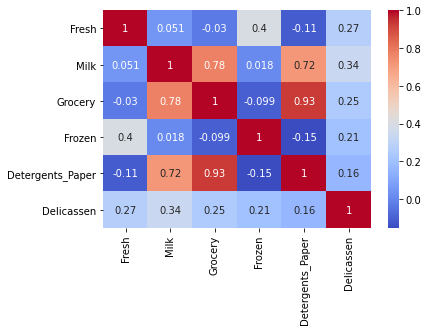

In [310]:
sns.heatmap(df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].corr(), cmap="coolwarm", annot=True)
# Grocery is correlated with Milk and Detergents_Paper

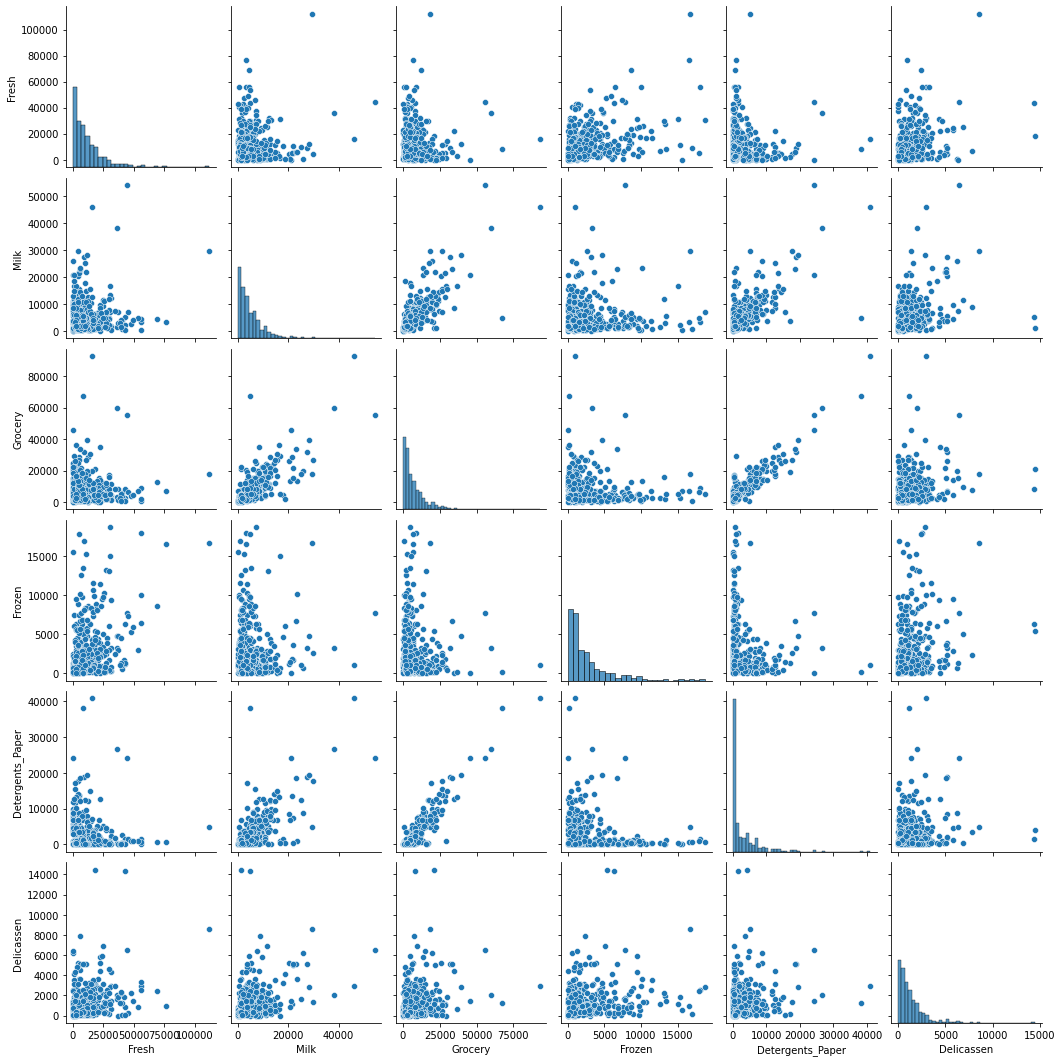

In [311]:
sns.pairplot(df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]])

<AxesSubplot:xlabel='Grocery', ylabel='Detergents_Paper'>

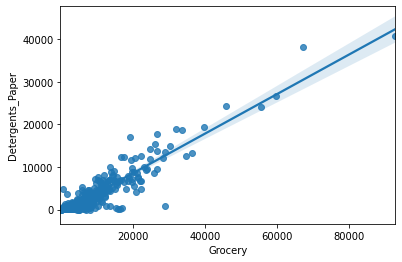

In [312]:
sns.regplot(x="Grocery", y="Detergents_Paper", data=df[["Grocery", "Detergents_Paper"]])

<AxesSubplot:xlabel='Grocery', ylabel='Milk'>

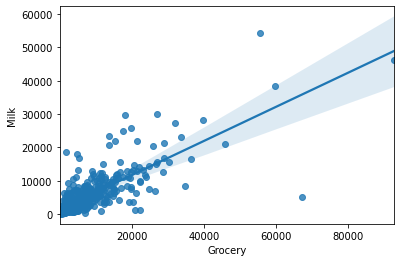

In [313]:
sns.regplot(x="Grocery", y="Milk", data=df[["Grocery", "Milk"]])

<AxesSubplot:xlabel='Detergents_Paper', ylabel='Milk'>

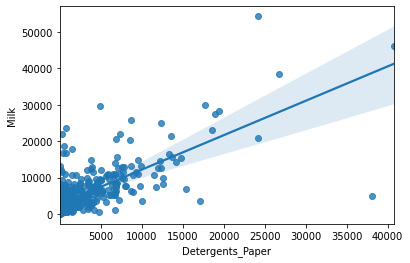

In [314]:
sns.regplot(x="Detergents_Paper", y="Milk", data=df[["Milk", "Detergents_Paper"]])

In [315]:
df11 = df[(df["Channel"] == 1) & (df["Region"] == 1)]
df12 = df[(df["Channel"] == 1) & (df["Region"] == 2)]
df13 = df[(df["Channel"] == 1) & (df["Region"] == 3)]
df21 = df[(df["Channel"] == 2) & (df["Region"] == 1)]
df22 = df[(df["Channel"] == 2) & (df["Region"] == 2)]
df23 = df[(df["Channel"] == 2) & (df["Region"] == 3)]

In [316]:
dfs = [df11, df12, df13, df21, df22, df23]
types = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
for kind in types:
    print("------------------------")
    print(kind)    
    print("------------------------")
    for df in dfs:
        print("Mean", df[kind].mean().round())
    for df in dfs:
        print("Var", df[kind].var().round())
    for df in dfs:
        print("SD", df[kind].std().round())

------------------------
Fresh
------------------------
Mean 12902.0
Mean 10870.0
Mean 13780.0
Mean 5200.0
Mean 7290.0
Mean 9544.0
Var 152325184.0
Var 65842417.0
Var 216974796.0
Var 29327873.0
Var 47168525.0
Var 90214295.0
SD 12342.0
SD 8114.0
SD 14730.0
SD 5416.0
SD 6868.0
SD 9498.0
------------------------
Milk
------------------------
Mean 3870.0
Mean 1768.0
Mean 3295.0
Mean 10784.0
Mean 9191.0
Mean 10127.0
Var 18475565.0
Var 789075.0
Var 12612961.0
Var 43681808.0
Var 43710004.0
Var 68619819.0
SD 4298.0
SD 888.0
SD 3551.0
SD 6609.0
SD 6611.0
SD 8284.0
------------------------
Grocery
------------------------
Mean 4026.0
Mean 4054.0
Mean 3818.0
Mean 18472.0
Mean 16326.0
Mean 15738.0
Var 13174317.0
Var 6251140.0
Var 11741901.0
Var 108465723.0
Var 196993963.0
Var 151261787.0
SD 3630.0
SD 2500.0
SD 3427.0
SD 10415.0
SD 14035.0
SD 12299.0
------------------------
Frozen
------------------------
Mean 3127.0
Mean 3703.0
Mean 3350.0
Mean 2584.0
Mean 1541.0
Mean 1483.0
Var 10735191.0
Var 150

In [317]:
#Observations: 
# Channel 1 Region 3 is the largest region (211 total rows)
# Channel 2 Region 3 is next largest (105 total rows)
#Channel 1, Region 1 is next largest (59 total rows)
#Channel 1, Region 2 is next, (28 total rows)
#The rest have less than 20 rows each

In [318]:
df13["gmm"].value_counts().sort_values(ascending=False)

0     57
3     57
2     40
10    29
9     10
5      8
4      6
8      2
Name: gmm, dtype: int64

In [319]:
df13.groupby(["gmm"])[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].agg(["mean", "std", "var"])

Fresh                                      Milk               \
             mean           std           var          mean          std   
gmm                                                                        
0     7099.526316   5141.833331  2.643845e+07   1556.473684  1162.500155   
2    17609.100000  14224.990557  2.023504e+08   4341.725000  1780.355021   
3    16052.368421  11334.924405  1.284805e+08   1547.508772   748.571857   
4     2277.333333   2215.407743  4.908031e+06   5481.833333  1704.250852   
5    14213.250000  10148.933354  1.030008e+08   6213.500000  2492.325306   
8    30778.000000  17659.284753  3.118503e+08   3145.500000  2658.014390   
9    44723.300000  33578.116561  1.127490e+09  12544.400000  9291.729324   
10    7583.689655   8178.007276  6.687980e+07   4268.379310  2540.291243   

                        Grocery                                   Frozen  \
              var          mean          std           var          mean   
gmm                                                                        
0    1.351407e+06   1757.947368   874.850220  7.653629e+05   1244.596491   
2    3.169664e+06   3992.650000  1900.497392  3.611890e+06   6587.800000   
3    5.603598e+05   2169.052632  1147.741438  1.317310e+06   3585.666667   
4    2.904471e+06  11601.000000  3487.890193  1.216538e+07    309.000000   
5    6.211685e+06   8960.500000  2808.384131  7.887021e+06   2807.125000   
8    7.065040e+06  14579.500000  9139.355147  8.352781e+07   5842.500000   
9    8.633623e+07   9493.900000  5675.509815  3.221141e+07  10769.800000   
10   6.453080e+06   5135.724138  2053.799178  4.218091e+06    604.551724   

                               Detergents_Paper                             \
             std           var             mean          std           var   
gmm                                                                          
0     860.345339  7.401941e+05       359.561404   332.233568  1.103791e+05   
2    4533.896446  2.055622e+07       657.700000   427.295022  1.825810e+05   
3    2514.937093  6.324909e+06       266.666667   169.812852  2.883640e+04   
4     209.052147  4.370280e+04      4169.333333  2531.006177  6.405992e+06   
5    1876.138088  3.519894e+06      2613.750000  1172.565776  1.374910e+06   
8     663.973268  4.408605e+05      2876.000000  1834.234990  3.364418e+06   
9    6089.853780  3.708632e+07      1182.800000  1495.053236  2.235184e+06   
10    408.439241  1.668226e+05      1385.206897  1047.047324  1.096308e+06   

       Delicassen                             
             mean          std           var  
gmm                                           
0      432.333333   274.391817  7.529087e+04  
2     1880.175000  1480.803730  2.192780e+06  
3     1041.368421   639.019523  4.083460e+05  
4     1013.666667   777.619616  6.046923e+05  
5     2503.500000  1464.832414  2.145734e+06  
8    14411.500000    85.559921  7.320500e+03  
9     3274.300000  2330.576946  5.431589e+06  
10     787.344828   543.556757  2.954539e+05

In [326]:
print(df23["gmm"].value_counts().sort_values(ascending=False))
print(df23[df23["gmm"]==0])
print(df23[df23["gmm"]==1])

5     32
4     27
6     20
10    17
7      3
2      2
0      1
1      1
Name: gmm, dtype: int64
    Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  \
11        2       3  13146  1124     4523    1420               549   

    Delicassen  gmm  
11         497    0  
    Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
65        2       3     85  20959    45828      36             24231   

    Delicassen  gmm  
65        1423    1  


In [327]:
df23 = df23.drop(index=11, axis=0)
df23 = df23.drop(index=65, axis=1)

In [328]:
df23.groupby(["gmm"])[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].agg(["mean", "std", "var"])

Fresh                                      Milk               \
             mean           std           var          mean          std   
gmm                                                                        
2    29789.000000  13986.572132  1.956242e+08   4638.000000   981.464212   
4     1865.074074   1883.722602  3.548411e+06   8202.333333  3238.883794   
5    12472.687500   8026.812429  6.442972e+07   7674.875000  1924.082500   
6     7460.050000   5651.581693  3.194038e+07  16038.300000  6461.558995   
7    32175.000000  14545.073633  2.115592e+08  46275.000000  7945.287157   
10   12646.588235   9051.812181  8.193530e+07   5004.470588  2167.113348   

                        Grocery                                   Frozen  \
              var          mean           std           var         mean   
gmm                                                                        
2    9.632720e+05   6834.000000   2657.307284  7.061282e+06  4748.000000   
4    1.049037e+07  14807.000000   4300.160426  1.849138e+07   536.481481   
5    3.702093e+06  10705.500000   2473.008916  6.115773e+06  2106.218750   
6    4.175174e+07  24120.650000   5597.587321  3.133298e+07  1795.200000   
7    6.312759e+07  69316.333333  20419.645500  4.169619e+08  4020.666667   
10   4.696380e+06   7310.058824   2145.334720  4.602461e+06   702.529412   

                               Detergents_Paper                             \
             std           var             mean          std           var   
gmm                                                                          
2    4785.698695  2.290291e+07       643.500000   170.412734  2.904050e+04   
4     423.463955  1.793217e+05      6632.962963  1907.352746  3.637994e+06   
5    1299.860135  1.689636e+06      4437.093750  1579.655972  2.495313e+06   
6    1092.630558  1.193842e+06     10709.900000  4404.119446  1.939627e+07   
7    3442.632326  1.185172e+07     30566.333333  8975.588300  8.056119e+07   
10    486.605990  2.367854e+05      2763.058824   915.945991  8.389571e+05   

      Delicassen                             
            mean          std           var  
gmm                                          
2    1441.500000  1122.178462  1.259284e+06  
4    1146.222222   833.812298  6.952429e+05  
5    2105.968750  1735.550791  3.012137e+06  
6    2204.200000  1944.005891  3.779159e+06  
7    3808.666667  2346.681132  5.506912e+06  
10    922.000000   744.179918  5.538038e+05

In [325]:
df11.groupby(["gmm"])[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].agg(["mean", "std", "var"])

Fresh                                      Milk               \
             mean           std           var          mean          std   
gmm                                                                        
0     8064.714286   4352.288619  1.894242e+07   1362.785714  1280.774596   
2    29524.777778  18348.996170  3.366857e+08   3638.555556  1783.322048   
3    14762.400000   9273.608543  8.599982e+07   1538.333333   858.825167   
4     4101.000000   1831.406563  3.354050e+06   9134.000000  2306.582320   
5    11589.000000  12240.517827  1.498303e+08   4695.500000  3679.187003   
9    13830.333333  10099.425000  1.019984e+08  17662.000000  6025.983322   
10    5426.583333   5501.640292  3.026805e+07   5283.750000  2578.056284   

                        Grocery                                  Frozen  \
              var          mean          std           var         mean   
gmm                                                                       
0    1.640384e+06   1578.857143   685.790600  4.703087e+05  1489.928571   
2    3.180238e+06   4497.777778  2129.404246  4.534362e+06  6990.222222   
3    7.375807e+05   2392.333333  1352.607781  1.829548e+06  3787.533333   
4    5.320322e+06  13092.000000  3459.166374  1.196583e+07   732.500000   
5    1.353642e+07   9087.500000  6396.446018  4.091452e+07  2735.750000   
9    3.631248e+07   9312.333333  4478.144072  2.005377e+07  6635.333333   
10   6.646374e+06   4050.166667  2016.133601  4.064795e+06   967.833333   

                               Detergents_Paper                             \
             std           var             mean          std           var   
gmm                                                                          
0     781.505890  6.107515e+05       316.214286   274.236613  7.520572e+04   
2    5064.355531  2.564770e+07       689.222222   229.163576  5.251594e+04   
3    2524.233487  6.371755e+06       258.000000   199.454614  3.978214e+04   
4     907.218000  8.230445e+05      4997.500000  1174.504364  1.379460e+06   
5    2264.640718  5.128598e+06      2498.250000  1452.594317  2.110030e+06   
9    3054.005621  9.326950e+06       887.000000   633.426397  4.012290e+05   
10    438.869588  1.926065e+05      1577.666667  1593.602114  2.539568e+06   

      Delicassen                             
            mean          std           var  
gmm                                          
0     432.071429   251.907023  6.345715e+04  
2    2112.333333  1212.637621  1.470490e+06  
3     979.733333   581.200416  3.377939e+05  
4    1313.500000  1519.572473  2.309100e+06  
5    1189.750000   657.482763  4.322836e+05  
9    4585.000000  1973.747958  3.895681e+06  
10    811.250000   668.467600  4.468489e+05